In [2]:
import os
from dotenv import load_dotenv
import pandas as pd
from langchain_groq import ChatGroq
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_core.messages import HumanMessage, SystemMessage, ToolMessage
from langchain.tools import tool
from langgraph.graph import StateGraph, START, END
from typing import Annotated, Sequence, List
from langchain_core.messages import BaseMessage
from langchain_core.documents import Document
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY", "")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY", "")

In [4]:
# Load and parse CSV file
csv_file_path = 'data/structured_files/IMDB-Movie-Data.csv'
df_movies = pd.read_csv(csv_file_path)

print("CSV Data Preview:")
print(df_movies.head())
print(f"\nShape: {df_movies.shape}")
print(f"Columns: {df_movies.columns.tolist()}")

CSV Data Preview:
   Rank                    Title                     Genre  \
0     1  Guardians of the Galaxy   Action,Adventure,Sci-Fi   
1     2               Prometheus  Adventure,Mystery,Sci-Fi   
2     3                    Split           Horror,Thriller   
3     4                     Sing   Animation,Comedy,Family   
4     5            Suicide Squad  Action,Adventure,Fantasy   

                                         Description              Director  \
0  A group of intergalactic criminals are forced ...            James Gunn   
1  Following clues to the origin of mankind, a te...          Ridley Scott   
2  Three girls are kidnapped by a man with a diag...    M. Night Shyamalan   
3  In a city of humanoid animals, a hustling thea...  Christophe Lourdelet   
4  A secret government agency recruits some of th...            David Ayer   

                                              Actors  Year  Runtime (Minutes)  \
0  Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...  2014 

In [5]:
def process_csv_to_documents(filepath: str) -> List[Document]:
    df = pd.read_csv(filepath)
    documents = []
    
    for idx, row in df.iterrows():
        content = f"""Movie: {row['Title']}
Rank: {row['Rank']}
Genre: {row['Genre']}
Director: {row['Director']}
Actors: {row['Actors']}
Year: {row['Year']}
Runtime: {row['Runtime (Minutes)']} minutes
Rating: {row['Rating']}
Votes: {row['Votes']}
Revenue: ${row['Revenue (Millions)']} million
Metascore: {row['Metascore']}
Description: {row['Description']}"""
        
        doc = Document(
            page_content=content.strip(),
            metadata={
                'source': filepath,
                'row_index': idx,
                'title': row['Title'],
                'genre': row['Genre'],
                'year': row['Year'],
                'rating': row['Rating'],
                'director': row['Director']
            }
        )
        documents.append(doc)
    
    return documents

csv_documents = process_csv_to_documents(csv_file_path)
print(f"\nCreated {len(csv_documents)} documents from CSV")
print(f"\nSample document:")
print(csv_documents[0].page_content[:300])


Created 1000 documents from CSV

Sample document:
Movie: Guardians of the Galaxy
Rank: 1
Genre: Action,Adventure,Sci-Fi
Director: James Gunn
Actors: Chris Pratt, Vin Diesel, Bradley Cooper, Zoe Saldana
Year: 2014
Runtime: 121 minutes
Rating: 8.1
Votes: 757074
Revenue: $333.13 million
Metascore: 76
Description: A group of intergalactic criminals are


In [6]:
excel_file_path = 'data/structured_files/inventory.xlsx'

def process_excel_to_documents(filepath: str) -> List[Document]:
    documents = []
    excel_file = pd.ExcelFile(filepath)
    
    for sheet_name in excel_file.sheet_names:
        df = pd.read_excel(filepath, sheet_name=sheet_name)
        
        for idx, row in df.iterrows():
            if sheet_name == 'Products':
                content = f"""Product: {row['Product']}
Category: {row['Category']}
Price: ${row['Price']}
Stock: {row['Stock']} units
Description: {row['Description']}
Sheet: {sheet_name}"""
            else:
                content = f"""Category: {row['Category']}
Total Items: {row['Total_Items']}
Total Value: ${row['Total_Value']}
Sheet: {sheet_name}"""
            
            doc = Document(
                page_content=content.strip(),
                metadata={
                    'source': filepath,
                    'sheet_name': sheet_name,
                    'row_index': idx
                }
            )
            documents.append(doc)
    
    return documents

excel_documents = process_excel_to_documents(excel_file_path)
print(f"\nCreated {len(excel_documents)} documents from Excel")


Created 7 documents from Excel


In [7]:
all_documents = csv_documents + excel_documents
print(f"\nTotal documents: {len(all_documents)}")


Total documents: 1007


In [15]:
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = FAISS.from_documents(
    documents=all_documents,
    embedding=embeddings
)

print("\nVector store created successfully")
print(f"Number of vectors: {vectorstore.index.ntotal}")


Vector store created successfully
Number of vectors: 1007


In [16]:
vectorstore.save_local("movie_product_vectorstore")
print("\nVector store saved to disk at 'movie_product_vectorstore'")


Vector store saved to disk at 'movie_product_vectorstore'


In [17]:
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 7}
)

print("\nRetriever configured")


Retriever configured


In [18]:
test_query = "Tell me about action movies"
retrieved_docs = retriever.invoke(test_query)

print(f"\nTest retrieval for: '{test_query}'")
print(f"Retrieved {len(retrieved_docs)} documents")
print(f"\nFirst retrieved document:")
print(retrieved_docs[0].page_content[:300])


Test retrieval for: 'Tell me about action movies'
Retrieved 7 documents

First retrieved document:
Movie: Faster
Rank: 705
Genre: Action,Crime,Drama
Director: George Tillman Jr.
Actors: Dwayne Johnson, Billy Bob Thornton, Maggie Grace, Mauricio Lopez
Year: 2010
Runtime: 98 minutes
Rating: 6.5
Votes: 83788
Revenue: $23.23 million
Metascore: 44
Description: An ex-con gets on a series of apparently 


In [19]:
class QueryInput(BaseModel):
    query: str = Field(description="The search query to find relevant movies or products")

@tool(args_schema=QueryInput)
def query_vector_database(query: str) -> str:
    """Search the movie and product database for relevant information"""
    retrieved_docs = retriever.invoke(query)
    context = "\n\n---\n\n".join([doc.page_content for doc in retrieved_docs])
    return context

print("\nTool created")


Tool created


In [20]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [21]:
def agent(state: AgentState):
    print("---CALL AGENT---")
    messages = state["messages"]
    
    # Get the user query
    user_query = messages[0].content
    print(f"Retrieving context for: {user_query}")
    
    # Call tool directly to get context
    tool_result = query_vector_database.invoke({"query": user_query})
    
    # Create a tool message
    tool_msg = ToolMessage(
        content=tool_result,
        tool_call_id="retrieval_call"
    )
    
    return {"messages": [tool_msg]}

In [22]:
def responder(state: AgentState):
    print("---GENERATE RESPONSE---")
    messages = state["messages"]
    
    # Get the tool result (retrieved context)
    tool_message = messages[-1]
    retrieved_context = tool_message.content
    
    # Get original question
    question = messages[0].content
    
    system_prompt = """You are a helpful assistant with access to a database of movies and products.
Use the retrieved information to answer the user's question accurately and clearly.
Provide specific details like names, numbers, and facts from the data.
If the information is not available in the retrieved data, say so."""
    
    llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0)
    
    response = llm.invoke([
        SystemMessage(content=system_prompt),
        HumanMessage(content=f"Context: {retrieved_context}\n\nQuestion: {question}")
    ])
    
    return {"messages": [response]}

In [23]:
workflow = StateGraph(AgentState)

workflow.add_node("agent", agent)
workflow.add_node("responder", responder)

workflow.add_edge(START, "agent")
workflow.add_edge("agent", "responder")
workflow.add_edge("responder", END)

graph = workflow.compile()

print("\nWorkflow graph compiled successfully")


Workflow graph compiled successfully


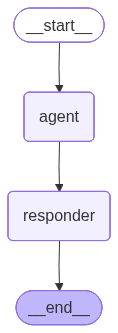

In [24]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except:
    print("Graph visualization not available")

In [25]:
query1 = "What are the top rated action movies?"
response = graph.invoke({"messages": [HumanMessage(content=query1)]})
print(f"Query: {query1}")
print(f"\nAnswer: {response['messages'][-1].content}")

---CALL AGENT---
Retrieving context for: What are the top rated action movies?
---GENERATE RESPONSE---
Query: What are the top rated action movies?

Answer: Based on the provided data, the top-rated action movies are:

1. The Bourne Ultimatum (2007) - Rating: 8.1
2. John Wick (2014) - Rating: 7.2
3. Furious Seven (2015) - Rating: 7.2
4. RED (2010) - Rating: 7.1

These movies have the highest ratings among the action movies listed in the data. Note that the ratings are based on the average votes from 283,282 to 525,700 users, depending on the movie.


In [50]:
query2 = "Tell me about Guardians of the Galaxy"
response = graph.invoke({"messages": [HumanMessage(content=query2)]})
print(f"\nQuery: {query2}")
print(f"\nAnswer: {response['messages'][-1].content}")

---CALL AGENT---
Retrieving context for: Tell me about Guardians of the Galaxy
---GENERATE RESPONSE---

Query: Tell me about Guardians of the Galaxy

Answer: Guardians of the Galaxy is a 2014 science fiction film directed by James Gunn. The movie has a runtime of 121 minutes and features an ensemble cast, including Chris Pratt, Vin Diesel, Bradley Cooper, and Zoe Saldana. 

The film has received widespread critical acclaim, with a rating of 8.1 based on 757,074 votes. It has also been a commercial success, generating $333.13 million in revenue. The Metascore for the movie is 76, indicating generally favorable reviews.

The movie's plot revolves around a group of intergalactic criminals who are forced to work together to stop a fanatical warrior from taking control of the universe. The film is classified under the genres of Action, Adventure, and Sci-Fi.

Interestingly, James Gunn, the director of Guardians of the Galaxy, has also directed another movie in the database, Super (2010), wh

In [26]:
query3 = "What electronics products are available?"
response = graph.invoke({"messages": [HumanMessage(content=query3)]})
print(f"\nQuery: {query3}")
print(f"\nAnswer: {response['messages'][-1].content}")

---CALL AGENT---
Retrieving context for: What electronics products are available?
---GENERATE RESPONSE---

Query: What electronics products are available?

Answer: The available electronics products are:

1. Webcam - a 1080p webcam with noise cancellation, priced at $89.99.
2. Laptop - a high-performance laptop with 16GB RAM and 512GB SSD, priced at $999.99.
3. Monitor - a 27-inch 4K monitor with HDR support, priced at $299.99.

These products have a total value of $1389.97.


In [27]:
query4 = "Which movies did James Gunn direct?"
response = graph.invoke({"messages": [HumanMessage(content=query4)]})
print(f"\nQuery: {query4}")
print(f"\nAnswer: {response['messages'][-1].content}")

---CALL AGENT---
Retrieving context for: Which movies did James Gunn direct?
---GENERATE RESPONSE---

Query: Which movies did James Gunn direct?

Answer: James Gunn directed the following movies:

1. Guardians of the Galaxy (2014)
2. Super (2010)
3. Slither (2006)

These three movies are listed in the provided data as being directed by James Gunn.


In [28]:
query5 = "What horror movies from 2016 are in the database?"
response = graph.invoke({"messages": [HumanMessage(content=query5)]})
print(f"\nQuery: {query5}")
print(f"\nAnswer: {response['messages'][-1].content}")

---CALL AGENT---
Retrieving context for: What horror movies from 2016 are in the database?
---GENERATE RESPONSE---

Query: What horror movies from 2016 are in the database?

Answer: The horror movies from 2016 in the database are:

1. The Black Room (Rank: 402, Genre: Horror, Director: Rolfe Kanefsky)
2. 31 (Rank: 777, Genre: Horror, Thriller, Director: Rob Zombie)
3. Friend Request (Rank: 532, Genre: Horror, Thriller, Director: Simon Verhoeven)


In [29]:
query6 = "Which movie had the highest revenue?"
response = graph.invoke({"messages": [HumanMessage(content=query6)]})
print(f"\nQuery: {query6}")
print(f"\nAnswer: {response['messages'][-1].content}")

---CALL AGENT---
Retrieving context for: Which movie had the highest revenue?
---GENERATE RESPONSE---

Query: Which movie had the highest revenue?

Answer: The movie with the highest revenue is Pirates of the Caribbean: On Stranger Tides, with a revenue of $241.06 million.


In [30]:
q = "What's the title, director, and rating of the movie with Rank 1?"

response = graph.invoke({"messages": [HumanMessage(content=q)]})

print(q)
print(response['messages'][-1].content)

---CALL AGENT---
Retrieving context for: What's the title, director, and rating of the movie with Rank 1?
---GENERATE RESPONSE---
What's the title, director, and rating of the movie with Rank 1?
The information for the movie with Rank 1 is not available in the retrieved data. The data only includes information for movies with ranks 747, 619, 970, 819, 119, 419, and 765. Therefore, I cannot provide the title, director, and rating of the movie with Rank 1.
